### SIDM with pyHalo

This notebook demonstrates how to generate realizations of self-interacting dark matter, in which a fraction of halos core collapse. 

In [6]:
from pyHalo.PresetModels.sidm import SIDM_core_collapse
from pyHalo.PresetModels.cdm import CDM
from pyHalo.realization_extensions import RealizationExtensions
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from lenstronomy.LensModel.lens_model import LensModel

### Fraction of collapsed halos as a function of halo mass

SIDM is parameterized in pyHalo through the fraction of collapsed halos as a function of halo mass. This was used by Gilman et al. (2023) to constrain SIDM cross sections https://ui.adsabs.harvard.edu/abs/2022arXiv220713111G/abstract. 

To use the SIDM_core_collapse preset model, you have to specify mass bins for both subhalos and field halos and the fraction of collapsed halos in each bin. In this implementation, halos have either collapsed (and therefore have a different density profile), or they have not collapsd (they have NFW profiles). 

There are two definitions of the collapsed density profile currently implemented. One is a cored power law
\begin{equation}
\rho\left(r, r_c, \gamma, \rho_0\right) = \rho_0 \left(1+\frac{r^2}{r_c^2}\right)^{-\gamma/2}
\end{equation}
The keyword arguments corrersponding to the parameters are $\gamma = $ log_slope_halo, $r_c = $ x_core_halo $\times \ r_s$ where $r_s$ is the scale radus of the original NFW profile, and $x_{\rm{match}}$ defines the normalization $\rho_0$ such that the new profile has the same mass enclosed within $x_{\rm{match}}$ as the original NFW profile. 

Another option is a "generalized NFW profile" 

\begin{equation}
\rho\left(r, r_s, \gamma_1, \gamma_2, \rho_0\right) = \rho_0 \left(\frac{r}{r_s}\right)^{-\gamma_1} \left(1 + \frac{r^2}{r_s^2}\right)^{\left(\gamma_1 - \gamma_2\right)/2}
\end{equation}
with a slope interior to $r_s$ of $\gamma_1$ ("gamma_inner"), a slope outside $r_s$ of $\gamma_2$ ("gamma_outer"), and $\rho_0$ again defined in terms of $x_{\rm{match}}$. 

${\bf{The \ newest, \ recommended}}$ setting is to specify the mass profile as TNFWC, a cored and truncated NFW-like profile 
\begin{equation}
\rho_{\rm{TNFWC}} = \frac{\rho_s \tau^2}{\sqrt{x^2+\beta^2}\left(1+x^2\right)\left(x^2+\tau^2\right)}
\end{equation}
One specifies the core size in units of $r_s$ through the "x_core_halo" argument, and the profile will explicitely conserve mass halo-by-halo. 

In [20]:
zlens, zsource = 0.5, 2.0
mass_ranges_subhalos = [[6.0, 7.0], [7.0, 8.0], [8.0, 9.0], [9.0, 10.0]]
mass_ranges_fieldhalos = [[6.0, 7.5], [7.5, 8.5], [8.5, 10.0]]
collapse_fraction_subhalos = [0.9, 0.7, 0.5, 0.2]
collapse_fraction_fieldhalos = [0.3, 0.2, 0.1]

cdm = CDM(zlens, zsource, sigma_sub=0.1, LOS_normalization=1.0, log_mlow=6.7)
ext = RealizationExtensions(cdm)

collapsed_halo_profile='SPL_CORE'
x_core_halo = 0.1
gamma = 2.7
# setting x_match = c means the collapsed halo will enclose the same mass inside the virial radius as the NFW profile
kwargs_collapsed_profile={'x_core_halo': x_core_halo, 'x_match': 'c', 'log_slope_halo': gamma}
# get the index of halos to make collapsed
index_collapsed = ext.core_collapse_by_mass(mass_ranges_subhalos, mass_ranges_fieldhalos,
                              collapse_fraction_subhalos, collapse_fraction_fieldhalos) 
realizationSIDM_1 = ext.add_core_collapsed_halos(index_collapsed, 
                                                halo_profile=collapsed_halo_profile,
                                                **kwargs_collapsed_profile)


collapsed_halo_profile='GNFW'
gamma_1 = 2.2
gamma_2 = 3.0
kwargs_collapsed_profile={'gamma_inner': gamma_1, 'gamma_outer': gamma_2, 'x_match': 'c'}
realizationSIDM_2 = ext.add_core_collapsed_halos(index_collapsed, 
                                                halo_profile=collapsed_halo_profile,
                                                **kwargs_collapsed_profile)

collapsed_halo_profile='TNFWC'
x_core_halo = 0.05
kwargs_collapsed_profile={'x_core_halo': x_core_halo}
realizationSIDM_3 = ext.add_core_collapsed_halos(index_collapsed, 
                                                halo_profile=collapsed_halo_profile,
                                                **kwargs_collapsed_profile)


### Now we can compute the effective multiplane convergence with SIDM halos

In [21]:
lens_model_list0, lens_redshift_array0, kwargs_halos0, _ = cdm.lensing_quantities()
lens_model_list1, lens_redshift_array1, kwargs_halos1, _ = realizationSIDM_1.lensing_quantities()
lens_model_list2, lens_redshift_array2, kwargs_halos2, _ = realizationSIDM_2.lensing_quantities()
lens_model_list3, lens_redshift_array3, kwargs_halos3, _ = realizationSIDM_3.lensing_quantities()


from lenstronomy.LensModel.lens_model import LensModel
astropy_instance = realizationSIDM_1.astropy_instance
npix = 120 
grid_size = 1.4
_x = _y = np.linspace(-grid_size, grid_size, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape

# power law plus shear macromodel
kwargs_macromodel = [{'theta_E': 1., 'center_x': 0., 'center_y': 0., 'e1': 0.2, 'e2': -0.1, 'gamma': 2.},
                    {'gamma1': -0.03, 'gamma2': 0.02}]

lens_model_list_macro = ['EPL', 'SHEAR']

lens_model_list_full0 = lens_model_list_macro + lens_model_list0
lens_model_list_full1 = lens_model_list_macro + lens_model_list1
lens_model_list_full2 = lens_model_list_macro + lens_model_list2
lens_model_list_full3 = lens_model_list_macro + lens_model_list3
kwargs_lens_full0 = kwargs_macromodel + kwargs_halos0
kwargs_lens_full1 = kwargs_macromodel + kwargs_halos1
kwargs_lens_full2 = kwargs_macromodel + kwargs_halos2
kwargs_lens_full3 = kwargs_macromodel + kwargs_halos3
lens_redshift_list_full0 = [zlens, zlens] + list(lens_redshift_array0)
lens_redshift_list_full1 = [zlens, zlens] + list(lens_redshift_array1)
lens_redshift_list_full2 = [zlens, zlens] + list(lens_redshift_array2)
lens_redshift_list_full3 = [zlens, zlens] + list(lens_redshift_array3)

lens_model_full0 = LensModel(lens_model_list_full0, zlens, zsource, 
                            lens_redshift_list_full0, 
                             cosmo=astropy_instance, 
                             multi_plane=True)
lens_model_full1 = LensModel(lens_model_list_full1, zlens, zsource, 
                            lens_redshift_list_full1, 
                             cosmo=astropy_instance, 
                             multi_plane=True)
lens_model_full2 = LensModel(lens_model_list_full2, zlens, zsource, 
                            lens_redshift_list_full2, 
                             cosmo=astropy_instance, 
                             multi_plane=True)
lens_model_full3 = LensModel(lens_model_list_full3, zlens, zsource, 
                            lens_redshift_list_full3, 
                             cosmo=astropy_instance, 
                             multi_plane=True)
lens_model_macro = LensModel(lens_model_list_macro)

kappa_full0 = lens_model_full0.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full0).reshape(shape0)
kappa_full1 = lens_model_full1.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full1).reshape(shape0)
kappa_full2 = lens_model_full2.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full2).reshape(shape0)
kappa_full3 = lens_model_full3.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full3).reshape(shape0)
kappa_macro = lens_model_macro.kappa(xx.ravel(), yy.ravel(), kwargs_macromodel).reshape(shape0)

# from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
# lens_model_extension = LensModelExtensions(lens_model_full0)
# grid_resolution = 0.1 # this can take a while for higher resolution computations of the critical curves
# ra_crit_list0, dec_crit_list0, _, _ = lens_model_extension.critical_curve_caustics(kwargs_lens_full0, 
#                                                                 compute_window=2*grid_size, grid_scale=grid_resolution)

# lens_model_extension = LensModelExtensions(lens_model_full1)
# ra_crit_list1, dec_crit_list1, _, _ = lens_model_extension.critical_curve_caustics(kwargs_lens_full1, 
#                                                                 compute_window=2*grid_size, grid_scale=grid_resolution)

# lens_model_extension = LensModelExtensions(lens_model_full2)
# ra_crit_list2, dec_crit_list2, _, _ = lens_model_extension.critical_curve_caustics(kwargs_lens_full2, 
#                                                                 compute_window=2*grid_size, grid_scale=grid_resolution)

# lens_model_extension = LensModelExtensions(lens_model_full3)
# ra_crit_list3, dec_crit_list3, _, _ = lens_model_extension.critical_curve_caustics(kwargs_lens_full3, 
#                                                                 compute_window=2*grid_size, grid_scale=grid_resolution)

### Make the kappa figure

Note: As you can see below, the TNFWC model is the most direct translation from CDM to SIDM,and explicitely conserves mass for tidally-stripped subhalos. This is the recommended model to use for SIDM

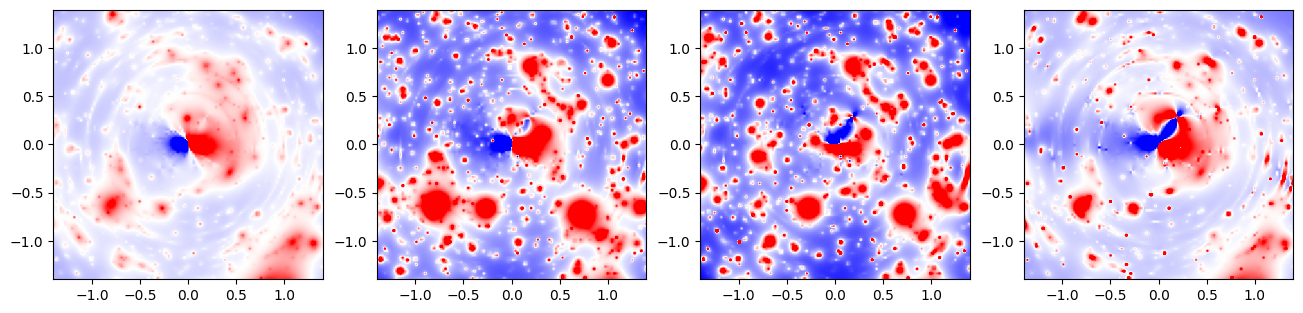

In [22]:
fig = plt.figure(1)
ax1 = plt.subplot(141)
ax2 = plt.subplot(142)
ax3 = plt.subplot(143)
ax4 = plt.subplot(144)
fig.set_size_inches(16,8)

kappa_subs = kappa_full0 - kappa_macro
mean = np.mean(kappa_subs)
ax1.imshow(kappa_subs - np.mean(kappa_subs), 
           vmin=-0.05, vmax=0.05, cmap='bwr', 
           extent=[-grid_size, grid_size, -grid_size, grid_size], origin='lower')

kappa_subs = kappa_full1 - kappa_macro
mean = np.mean(kappa_subs)
ax2.imshow(kappa_subs - np.mean(kappa_subs), 
           vmin=-0.05, vmax=0.05, cmap='bwr', 
           extent=[-grid_size, grid_size, -grid_size, grid_size], origin='lower')

kappa_subs = kappa_full2 - kappa_macro
mean = np.mean(kappa_subs)
ax3.imshow(kappa_subs - np.mean(kappa_subs), 
           vmin=-0.05, vmax=0.05, cmap='bwr', 
           extent=[-grid_size, grid_size, -grid_size, grid_size], origin='lower')

kappa_subs = kappa_full3 - kappa_macro
mean = np.mean(kappa_subs)
ax4.imshow(kappa_subs - np.mean(kappa_subs), 
           vmin=-0.05, vmax=0.05, cmap='bwr', 
           extent=[-grid_size, grid_size, -grid_size, grid_size], origin='lower')

# for i in range(0, len(ra_crit_list)):
#     plt.plot(ra_crit_list[i], dec_crit_list[i], color='k', lw=2)



### The above functionality is also loaded in a preset model

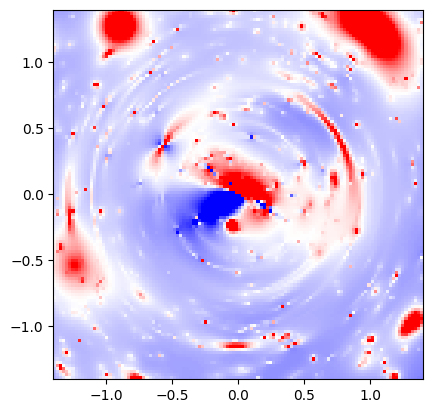

In [31]:
kwargs_collapsed_profile = {'x_core_halo': 0.05}
mass_ranges_subhalos = [[6, 10]]
mass_ranges_fieldhalos = [[6, 10]]
collapse_fraction_subhalos = [1.0] # all subhalos collapse
collapse_fraction_fieldhalos = [0.4] # 40% field halos collapse
sidm_core_collapse = SIDM_core_collapse(zlens, zsource, 
                                        mass_ranges_subhalos, mass_ranges_fieldhalos,
                                        collapse_fraction_subhalos, collapse_fraction_fieldhalos, log_mlow=6.7,
                                       collapsed_halo_profile='TNFWC', 
                                       kwargs_collapsed_profile=kwargs_collapsed_profile)
lens_model_list4, lens_redshift_array4, kwargs_halos4, _ = sidm_core_collapse.lensing_quantities()
lens_model_list_full4 = lens_model_list_macro + lens_model_list4
lens_redshift_list_full4 = [zlens, zlens] + list(lens_redshift_array4)
kwargs_lens_full4 = kwargs_macromodel + kwargs_halos4

lens_model_full4 = LensModel(lens_model_list_full4, zlens, zsource, 
                            lens_redshift_list_full4, 
                             cosmo=astropy_instance, 
                             multi_plane=True)
kappa_full4 = lens_model_full4.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full4).reshape(shape0)
kappa_subs = kappa_full4 - kappa_macro
mean = np.mean(kappa_subs)
plt.imshow(kappa_subs - np.mean(kappa_subs), 
           vmin=-0.05, vmax=0.05, cmap='bwr', 
           extent=[-grid_size, grid_size, -grid_size, grid_size], origin='lower')